# Taller de Análisis de Texto con Tweets en Español

Este taller guía a los estudiantes en el análisis de tweets en español, usando técnicas de limpieza de texto, análisis de frecuencia de palabras y análisis de sentimientos. También incluye preguntas orientadas al negocio.

In [ ]:
!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv

--2025-05-28 15:41:19--  https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv [following]
--2025-05-28 15:41:19--  https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205292 (200K) [text/plain]
Saving to: ‘Gender_bias_spanish.csv’

Gender_bias_s

## 1. Configuración e Importación de Librerías
Primero, importaremos las librerías necesarias y cargaremos el conjunto de datos.

In [ ]:
!pip install nltk textblob wordcloud
import pandas as pd
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Cargar el Conjunto de Datos
Cargamos el archivo CSV que contiene los tweets y las etiquetas ('biased' o 'non-biased').

In [ ]:
# Cargar el conjunto de datos (reemplazar 'ruta/del/archivo.csv' con la ruta del archivo real)
tweets = pd.read_csv('Gender_bias_spanish.csv')
tweets.head()

,Contents,Label
0,@chumeltorres ya cabrón! sin tí se reciben las...,biased
1,¿alguien es tan amable de ir a hacerme la comp...,non-biased
2,"@jenniferduquee hahaha, si está rico, nadamas ...",non-biased
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased
4,como siempre mi tortilla triunfa mas que otros...,non-biased


## 2. Exploración de Datos
Exploraremos el conjunto de datos para entender mejor la distribución de etiquetas y las características de los tweets.

In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Contents  1914 non-null   object
 1   Label     1914 non-null   object
dtypes: object(2)
memory usage: 30.0+ KB


In [ ]:
label_counts = tweets['Label'].value_counts()
print("Distribución de etiquetas:")
display(label_counts)


Distribución de etiquetas:


,count
Label,
non-biased,1596
biased,318


In [ ]:
tweets.isnull().sum()

,0
Contents,0
Label,0


In [ ]:
total_tweets = len(tweets)
biased_proportion = label_counts.get('biased', 0) / total_tweets * 100
non_biased_proportion = label_counts.get('non-biased', 0) / total_tweets * 100

print(f"\nProporción de tweets 'biased': {biased_proportion:.2f}%")
print(f"Proporción de tweets 'non-biased': {non_biased_proportion:.2f}%")


Proporción de tweets 'biased': 16.61%
Proporción de tweets 'non-biased': 83.39%


**Pregunta:** ¿Qué proporción de tweets son 'biased' y 'non-biased'? ¿Por qué podría ser importante esta proporción para el análisis de texto?

RTA: Este desequilibrio puede tener un impacto significativo en el rendimiento de un modelo de clasificación. Un modelo entrenado con estos datos podría ser muy bueno identificando tweets no sesgados, pero ineficaz para reconocer los tweets sesgados.

## 3. Preprocesamiento de Texto
Realizamos una serie de pasos para limpiar y preparar el texto para el análisis: limpieza de caracteres especiales, conversión a minúsculas, y eliminación de stopwords.

In [ ]:
def preprocess_text(text):

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|\#\w+', '', text)
    text = re.sub(r'[^a-zA-Záéíóúüñ\s]', '', text)
    tokens = text.split()
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(cleaned_tokens)

In [ ]:
tweets['cleaned_text'] = tweets['Contents'].apply(preprocess_text)
tweets.head()

,Contents,Label,cleaned_text
0,@chumeltorres ya cabrón! sin tí se reciben las...,biased,cabrón tí reciben noticias colchoncito puro ch...
1,¿alguien es tan amable de ir a hacerme la comp...,non-biased,alguien tan amable ir hacerme compra mañana ba...
2,"@jenniferduquee hahaha, si está rico, nadamas ...",non-biased,hahaha si rico nadamas falta presentación
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased,ves programa favorito sólo encuentro temporada...
4,como siempre mi tortilla triunfa mas que otros...,non-biased,siempre tortilla triunfa mas platos


## 4. Análisis de Frecuencia de Palabras por Etiqueta
Contamos las palabras en tweets 'biased' y 'non-biased' y visualizamos las palabras más comunes.

In [ ]:
biased_tweets = tweets[tweets['Label'] == 'biased']['cleaned_text']
non_biased_tweets = tweets[tweets['Label'] == 'non-biased']['cleaned_text']

In [ ]:
def get_top_words(text_series, n=10):
    all_words = ' '.join(text_series).split()
    return Counter(all_words).most_common(n)

In [ ]:
top_biased = get_top_words(biased_tweets)
top_non_biased = get_top_words(non_biased_tweets)
df_biased = pd.DataFrame(top_biased, columns=['word', 'count'])
df_non_biased = pd.DataFrame(top_non_biased, columns=['word', 'count'])

<ipython-input-14-36060e677a15>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=df_biased, palette='Greens_r')
<ipython-input-14-36060e677a15>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=df_non_biased, palette='Purples_r')


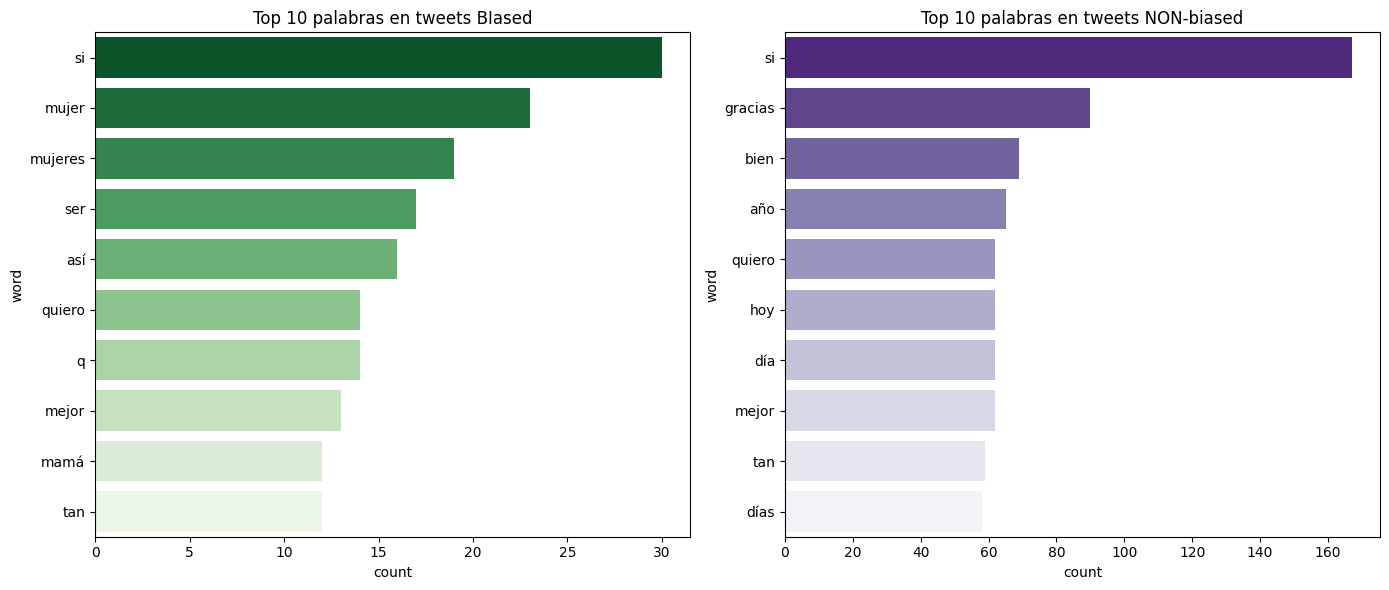

In [ ]:
import seaborn as sns

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='count', y='word', data=df_biased, palette='Greens_r')
plt.title('Top 10 palabras en tweets BIased')

plt.subplot(1, 2, 2)
sns.barplot(x='count', y='word', data=df_non_biased, palette='Purples_r')
plt.title('Top 10 palabras en tweets NON-biased')

plt.tight_layout()
plt.show()

**Preguntas de Análisis de Frecuencia:**
- ¿Qué palabras son más comunes en los tweets 'biased' en comparación con los 'non-biased'?
- ¿Hay palabras que sugieran un sesgo en los tweets etiquetados como 'biased'?
- ¿Cómo podrían usar las empresas esta información para entender mejor las opiniones sesgadas?

## 5. Análisis de Sentimientos
Usaremos `TextBlob` para calcular el sentimiento de cada tweet y luego compararemos la distribución de sentimientos entre tweets 'biased' y 'non-biased'.

In [ ]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

tweets['cleaned_text'] = tweets['Contents'].apply(preprocess_text)

tweets['sentiment_score'] = tweets['cleaned_text'].apply(get_sentiment)

print("Tweets with sentiment scores:")
display(tweets.head())

Tweets with sentiment scores:


,Contents,Label,cleaned_text,sentiment_score
0,@chumeltorres ya cabrón! sin tí se reciben las...,biased,cabrón tí reciben noticias colchoncito puro ch...,0.0
1,¿alguien es tan amable de ir a hacerme la comp...,non-biased,alguien tan amable ir hacerme compra mañana ba...,0.0
2,"@jenniferduquee hahaha, si está rico, nadamas ...",non-biased,hahaha si rico nadamas falta presentación,0.2
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased,ves programa favorito sólo encuentro temporada...,0.0
4,como siempre mi tortilla triunfa mas que otros...,non-biased,siempre tortilla triunfa mas platos,0.0


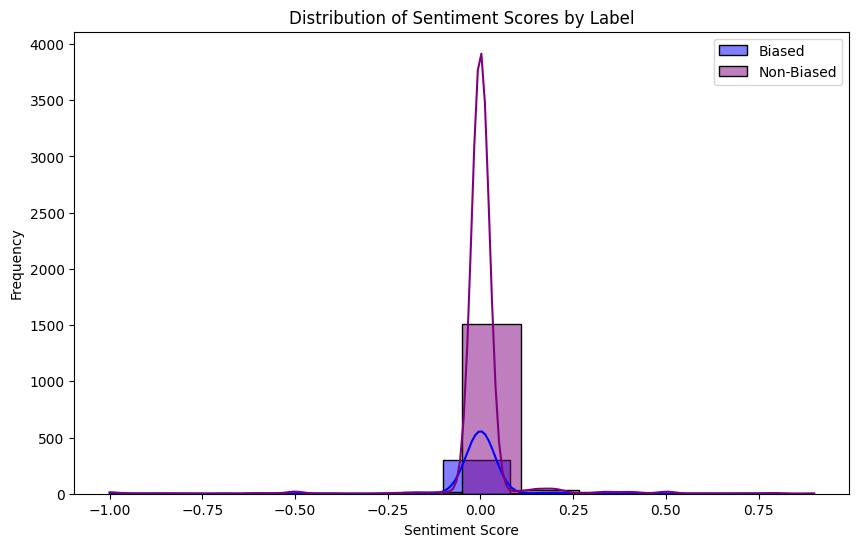

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(tweets[tweets['Label'] == 'biased']['sentiment_score'], color='blue', label='Biased', kde=True)
sns.histplot(tweets[tweets['Label'] == 'non-biased']['sentiment_score'], color='purple', label='Non-Biased', kde=True)
plt.title('Distribution of Sentiment Scores by Label')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Preguntas de Análisis de Sentimientos:**
- ¿Existe una diferencia notable en los sentimientos de tweets 'biased' vs 'non-biased'?
- ¿Qué indica esta diferencia sobre la naturaleza de los tweets sesgados?
- ¿Cómo podrías aplicar el análisis de sentimientos para entender la percepción del público sobre un tema específico?

## 6. Visualización con Nube de Palabras
Usamos una nube de palabras para visualizar las palabras más comunes en cada conjunto de tweets.

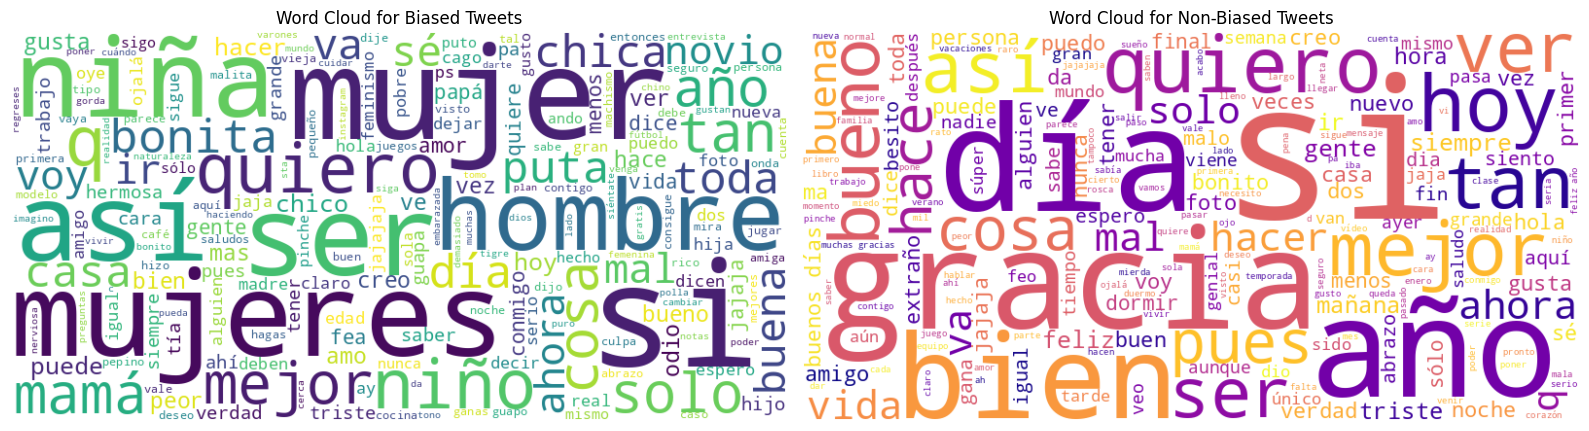

In [ ]:
biased_text_combined = ' '.join(biased_tweets)
non_biased_text_combined = ' '.join(non_biased_tweets)

biased_wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42, colormap='viridis').generate(biased_text_combined)

non_biased_wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42, colormap='plasma').generate(non_biased_text_combined)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(biased_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Biased Tweets')

plt.subplot(1, 2, 2)
plt.imshow(non_biased_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Biased Tweets')

plt.tight_layout()
plt.show()

## 7. Conclusiones y Perspectiva de Negocios
En este taller, hemos explorado cómo el análisis de texto puede ofrecer información valiosa sobre el contenido y el sentimiento de los tweets. Reflexionemos sobre algunas preguntas de negocio:
- ¿Cómo podría utilizarse este análisis para mejorar la comunicación de la marca?
- ¿Qué ajustes se podrían hacer en una campaña de marketing si los tweets son predominantemente 'biased'?
- ¿Qué patrones importantes se podrían explorar en un análisis futuro (e.g., análisis de tendencias a lo largo del tiempo)?